# Linear Regression with Synthetic Dataset

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from LAGS import LAGS, adaptive_LAGS
from metric import winning_rate

In [2]:
# general parameters
n = 1000
d = 10
cluster_size = 50
mode = "cancellation" # or "amplification"
ks = list(range(1, 101, 3)) + [100]

methods = ["LAGS", "Adaptive LAGS"]

test_size = 50
num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)

In [3]:
# generate a ground-truth linear model parameters
theta = np.random.uniform(-1, 1, d)

if mode == "cancellation":
    X_train = np.random.uniform(-1, 1, (n-2*cluster_size, d))
    X_train = np.vstack((np.ones((2*cluster_size, d)), X_train))
elif mode == "amplification":
    X_train = np.random.uniform(-1, 1, (n-cluster_size, d))
    X_train = np.vstack((np.ones((cluster_size, d)), X_train))

Y_train = (X_train @ theta).reshape(-1, 1)
noise = Y_train[0][0] * np.random.normal(1, 0.2, (cluster_size, 1))

if mode == "cancellation":
    Y_train[:cluster_size] += noise
    Y_train[cluster_size:2*cluster_size] -= noise
elif mode == "amplification":
    Y_train[:cluster_size] += 5*noise

print("Shape of features:", X_train.shape)
print("Shape of labels:", Y_train.shape)

X_test = np.random.uniform(-1, 1, (test_size, d))

Shape of features: (1000, 10)
Shape of labels: (1000, 1)


In [4]:
def actual_effect(X_train, Y_train, x_test, subset_to_remove, original_value):
    reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
    reduced_Y_train = np.delete(Y_train, subset_to_remove, axis=0)

    lr = LinearRegression().fit(reduced_X_train, reduced_Y_train)
    reduced_value = lr.predict(x_test.reshape(1, -1))

    return reduced_value - original_value

In [5]:
def score(i_th_test, k):
    x_test = X_test[i_th_test]
    lr = LinearRegression().fit(X_train, Y_train)
    original_value = lr.predict(x_test.reshape(1, -1))

    scores = np.array([
        actual_effect(X_train, Y_train, x_test, LAGS(X_train, Y_train, x_test)[:k], original_value),
        actual_effect(X_train, Y_train, x_test, adaptive_LAGS(X_train, Y_train, x_test, k=k), original_value),
    ])

    return scores

In [6]:
scores_array = np.array(Parallel(n_jobs=50)(delayed(score)(i, k) for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo
scores_ks_method = scores_ks_method_combo.mean(axis=2)

winning_result = np.array(Parallel(n_jobs=50)(delayed(winning_rate)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

In [7]:
palette = sns.color_palette("bright")
colors = [palette[9], palette[1]]

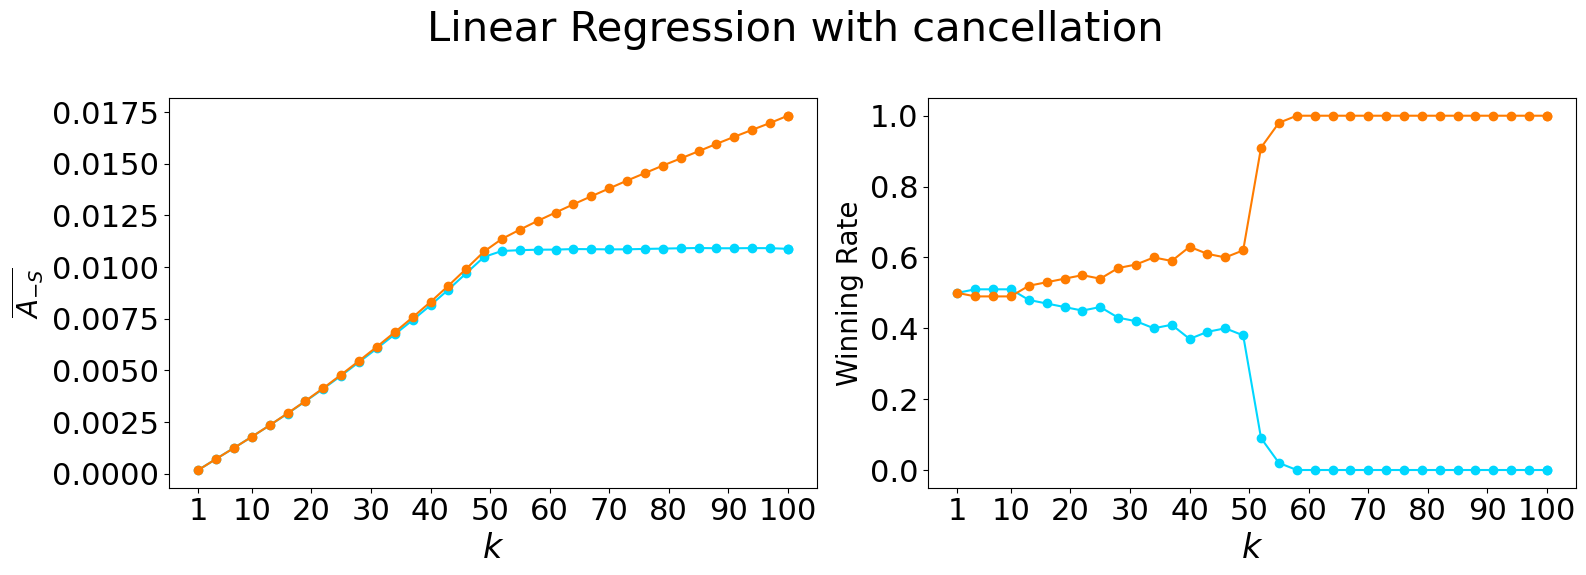

In [8]:
plt.figure(figsize=(16, 6))  # Create a single plot

plt.suptitle(f'Linear Regression with {mode}', fontsize=30)  # Overall title

# First subplot - Average Scores
plt.subplot(1, 2, 1)
# plt.title('Average Scores', fontsize=24)
plt.xlabel('$k$', fontsize=24)
plt.ylabel('$\overline{A_{-S}}$', fontsize=20)

for method_idx, method_name in enumerate(methods):
    plt.plot(ks, scores_ks_method[:, method_idx], marker='o', label=method_name, color=colors[method_idx])

plt.xticks(np.insert(np.arange(10, max(ks) + 1, 10), 0, 1), fontsize=22)
plt.yticks(fontsize=22)
# plt.legend(methods, fontsize=18)

# Second subplot - Winning Rate
plt.subplot(1, 2, 2)
# plt.title('Winning Rate', fontsize=24)
plt.xlabel('$k$', fontsize=24)
plt.ylabel('Winning Rate', fontsize=20)

for method_idx, method_name in enumerate(methods):
    plt.plot(ks, winning_result[:, method_idx], marker='o', label=method_name, color=colors[method_idx])

plt.xticks(np.insert(np.arange(10, max(ks) + 1, 10), 0, 1), fontsize=22)
plt.yticks(fontsize=22)
# plt.legend(methods, fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate overall title

plt.savefig(f'../Figures/Linear_Regression_{mode}.png', format='png', dpi=300)

## Visualization

In [9]:
# general parameters
n = 50
d = 1
cluster_size = 10
mode = "cancellation" # or "cancellation"
ks = list(range(1, 51, 3)) + [50]

# generate a ground-truth linear model parameters
theta = np.random.uniform(-1, 1, d)

if mode == "cancellation":
    X_train = np.random.uniform(-1, 1, (n-2*cluster_size, d))
    X_train = np.vstack((np.ones((2*cluster_size, d)), X_train))
elif mode == "amplification":
    X_train = np.random.uniform(-1, 1, (n-cluster_size, d))
    X_train = np.vstack((np.ones((cluster_size, d)), X_train))

Y_train = (X_train @ theta).reshape(-1, 1)
noise = Y_train[0][0] * np.random.normal(1, 0.2, (cluster_size, 1))

if mode == "cancellation":
    Y_train[:cluster_size] += noise
    Y_train[cluster_size:2*cluster_size] -= noise
elif mode == "amplification":
    Y_train[:cluster_size] += 5*noise

print("Shape of features:", X_train.shape)
print("Shape of labels:", Y_train.shape)

X_test = np.random.uniform(-1, 1, (test_size, d))

Shape of features: (50, 1)
Shape of labels: (50, 1)


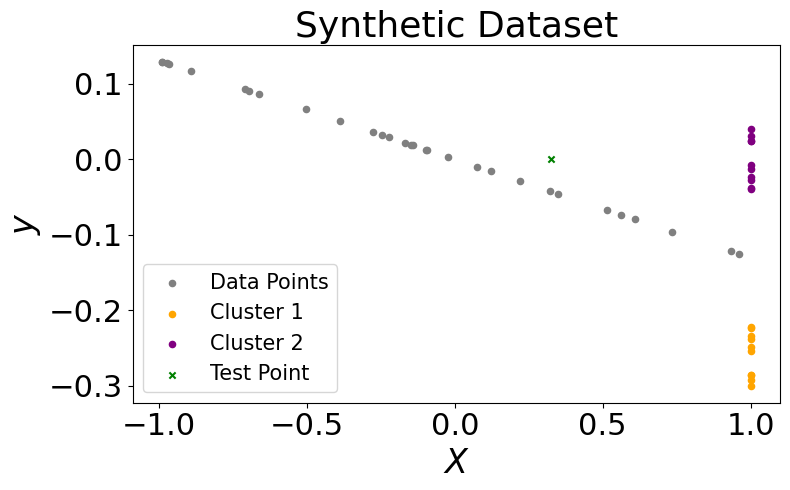

In [10]:
# Visualize all the data points with two clusters highlighted# Separate data points for each cluster
cluster1_X = X_train[:cluster_size]
cluster1_Y = Y_train[:cluster_size]

cluster2_X = X_train[cluster_size:2 * cluster_size]
cluster2_Y = Y_train[cluster_size:2 * cluster_size]

# Visualize all the data points with two clusters highlighted
plt.figure(figsize=(8, 5))
X_train_without_clusters = np.delete(X_train, range(2 * cluster_size), axis=0)
Y_train_without_clusters = np.delete(Y_train, range(2 * cluster_size), axis=0)
plt.scatter(X_train_without_clusters, Y_train_without_clusters, color='gray', label='Data Points', s=20)
plt.scatter(cluster1_X, cluster1_Y, color='orange', label='Cluster 1', s=20)
plt.scatter(cluster2_X, cluster2_Y, color='purple', label='Cluster 2', s=20)
plt.scatter(X_test[0], 0, color='green', marker='x', label='Test Point', s=20)
plt.xlabel('$X$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.xticks(np.arange(-1, 1.1, 0.5), fontsize=22)
plt.yticks(fontsize=22)
plt.title('Synthetic Dataset', fontsize=26)
plt.legend(fontsize=15)
plt.tight_layout()

plt.savefig('../Figures/Linear_Regression_synthetic_visual_dataset.png', format='png', dpi=300)
plt.show()

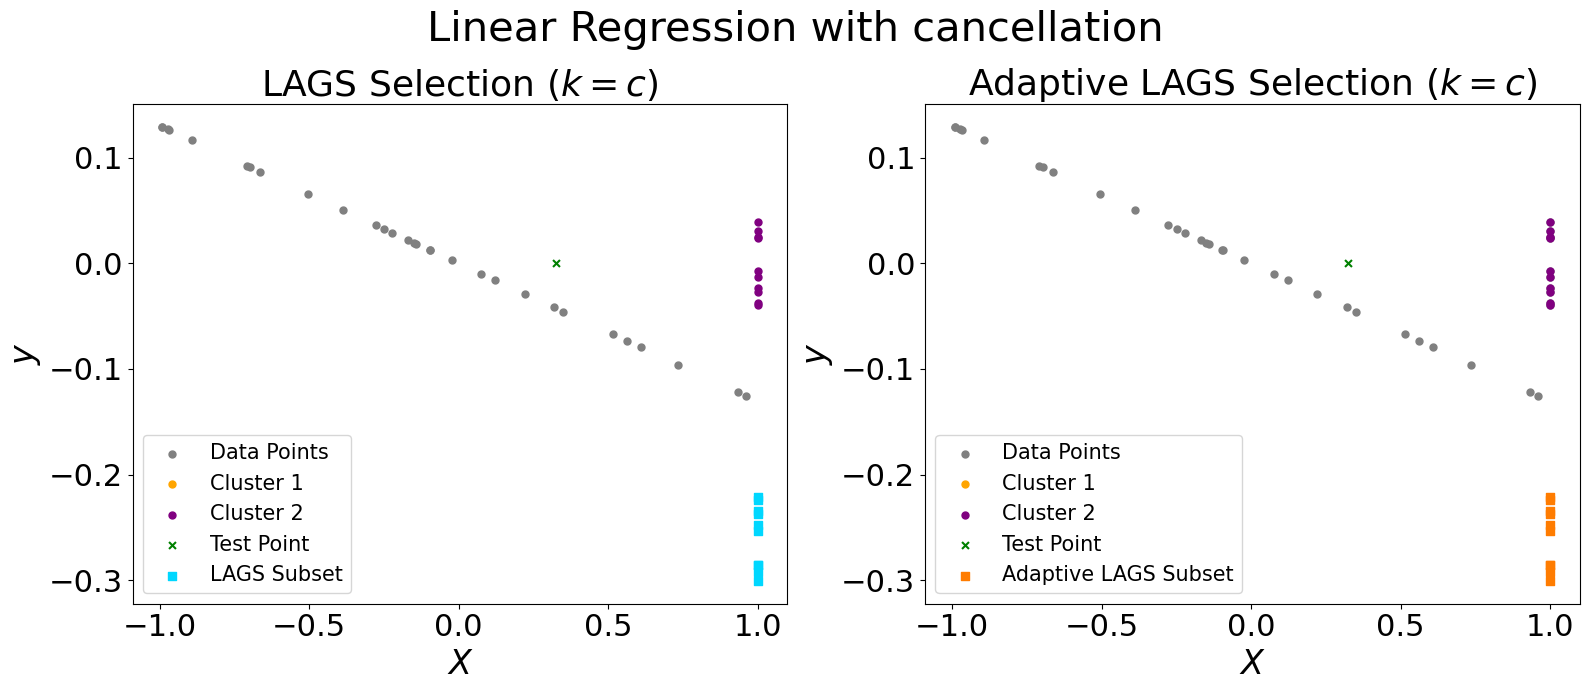

In [11]:
lags_50 = LAGS(X_train, Y_train, X_test[0])[:cluster_size]
adaptive_lags_50 = adaptive_LAGS(X_train, Y_train, X_test[0], k=cluster_size)

plt.figure(figsize=(16, 7))  # Create a single plot

plt.suptitle(f'Linear Regression with {mode}', fontsize=30)  # Overall title

# Plot for lags_50 subset
plt.subplot(1, 2, 1)
plt.scatter(X_train_without_clusters, Y_train_without_clusters, color='gray', label='Data Points', s=25)
plt.scatter(cluster1_X, cluster1_Y, color='orange', label='Cluster 1', s=25)
plt.scatter(cluster2_X, cluster2_Y, color='purple', label='Cluster 2', s=25)
plt.scatter(X_test[0], 0, color='green', marker='x', label='Test Point', s=25)
plt.scatter(X_train[lags_50], Y_train[lags_50], color=colors[0], marker='s', label='LAGS Subset', s=30)
plt.xlabel('$X$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.xticks(np.arange(-1, 1.1, 0.5), fontsize=22)
plt.yticks(fontsize=22)
plt.title('LAGS Selection ($k=c$)', fontsize=26)
plt.legend(fontsize=15)

# Plot for adaptive_lags_50 subset
plt.subplot(1, 2, 2)
plt.scatter(X_train, Y_train, color='gray', label='Data Points', s=25)
plt.scatter(cluster1_X, cluster1_Y, color='orange', label='Cluster 1', s=25)
plt.scatter(cluster2_X, cluster2_Y, color='purple', label='Cluster 2', s=25)
plt.scatter(X_test[0], 0, color='green', marker='x', label='Test Point', s=25)
plt.scatter(X_train[adaptive_lags_50], Y_train[adaptive_lags_50], color=colors[1], marker='s', label='Adaptive LAGS Subset', s=30)
plt.xlabel('$X$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.xticks(np.arange(-1, 1.1, 0.5), fontsize=22)
plt.yticks(fontsize=22)
plt.title('Adaptive LAGS Selection ($k=c$)', fontsize=26)
plt.legend(fontsize=15)

# Adjust layout
plt.tight_layout()

plt.savefig('../Figures/Linear_Regression_synthetic_visual_selection_first_cluster.png', format='png', dpi=300)

# Show plot
plt.show()

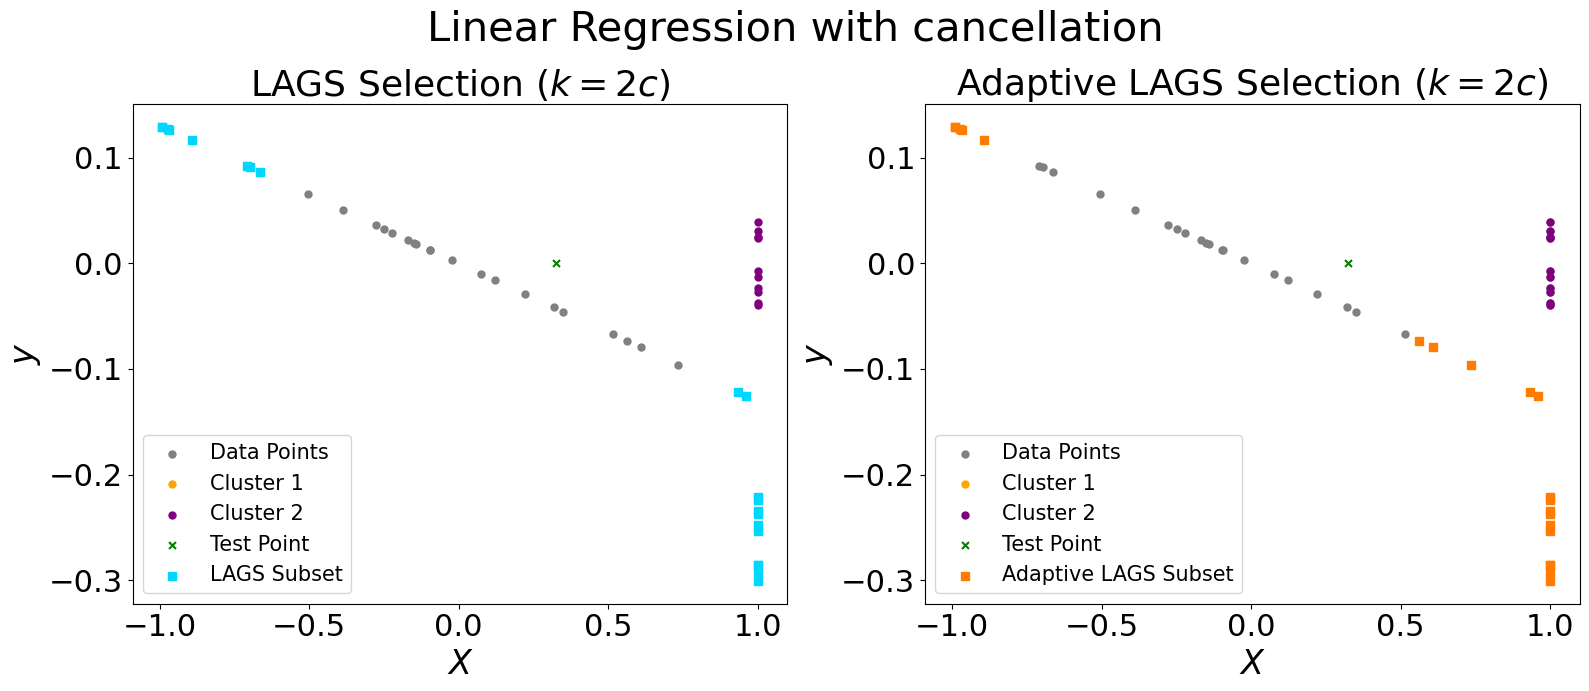

In [12]:
lags_50 = LAGS(X_train, Y_train, X_test[0])[:2*cluster_size]
adaptive_lags_50 = adaptive_LAGS(X_train, Y_train, X_test[0], k=2*cluster_size)

plt.figure(figsize=(16, 7))  # Create a single plot

plt.suptitle(f'Linear Regression with {mode}', fontsize=30)  # Overall title

# Plot for lags_50 subset
plt.subplot(1, 2, 1)
plt.scatter(X_train_without_clusters, Y_train_without_clusters, color='gray', label='Data Points', s=25)
plt.scatter(cluster1_X, cluster1_Y, color='orange', label='Cluster 1', s=25)
plt.scatter(cluster2_X, cluster2_Y, color='purple', label='Cluster 2', s=25)
plt.scatter(X_test[0], 0, color='green', marker='x', label='Test Point', s=25)
plt.scatter(X_train[lags_50], Y_train[lags_50], color=colors[0], marker='s', label='LAGS Subset', s=30)
plt.xlabel('$X$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.xticks(np.arange(-1, 1.1, 0.5), fontsize=22)
plt.yticks(fontsize=22)
plt.title('LAGS Selection ($k=2c$)', fontsize=26)
plt.legend(fontsize=15)

# Plot for adaptive_lags_50 subset
plt.subplot(1, 2, 2)
plt.scatter(X_train, Y_train, color='gray', label='Data Points', s=25)
plt.scatter(cluster1_X, cluster1_Y, color='orange', label='Cluster 1', s=25)
plt.scatter(cluster2_X, cluster2_Y, color='purple', label='Cluster 2', s=25)
plt.scatter(X_test[0], 0, color='green', marker='x', label='Test Point', s=25)
plt.scatter(X_train[adaptive_lags_50], Y_train[adaptive_lags_50], color=colors[1], marker='s', label='Adaptive LAGS Subset', s=30)
plt.xlabel('$X$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.xticks(np.arange(-1, 1.1, 0.5), fontsize=22)
plt.yticks(fontsize=22)
plt.title('Adaptive LAGS Selection ($k=2c$)', fontsize=26)
plt.legend(fontsize=15)

# Adjust layout
plt.tight_layout()

plt.savefig('../Figures/Linear_Regression_synthetic_visual_selection_second_cluster.png', format='png', dpi=300)

# Show plot
plt.show()